# FMCW Processing 

- need to understand why a single known target delay can estimate phase errors for ALL frequency bins? 
    - this assumes the phase error is constant across the sweep right?


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as sc

In [5]:
# Top Level Constants 
f_c_hz  = 10e9          # Carrier Frequency(hz)
B_hz    = 50e6          # Sweep Bandwidth(hz)
T_s     = 500e-6       # Sweep Period(s)
alpha   = B_hz / T_s    # Chirp Rate i.e. bandwidth over period (Hz/s)
fs = 2.1*(f_c_hz + (B_hz/2))    # Sampling Rate
n_samples = int(T_s*fs)        # num samples 1 period
target_distance_m = 10000       # Example target distance
tau  = (2 * target_distance_m)/sc.speed_of_light # Propogation delay for target

In [6]:
def phi_tx(t:np.ndarray,f_c_hz, alpha)->np.ndarray: 
    '''Phase equation for perfectly linear phase
        Args: 
            t(np array): time array 
            f_c_hz: carrier freq
            alpha: chirp rate
    '''
    return 2*np.pi * (f_c_hz + (1/2 * alpha*t**2))

def phi_tx_error(t:np.ndarray,f_c_hz, alpha, error_func)->np.ndarray: 
    return phi_tx(t,f_c_hz, alpha) + error_func


def basic_error_func(t:np.ndarray, a_sl, f_sl)->np.ndarray: 
    return a_sl * np.sin(2*np.pi*f_sl*t)

/var/folders/41/7_2p9h8s6zzg7br84x60t4lc0000gn/T/ipykernel_93752/670725419.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


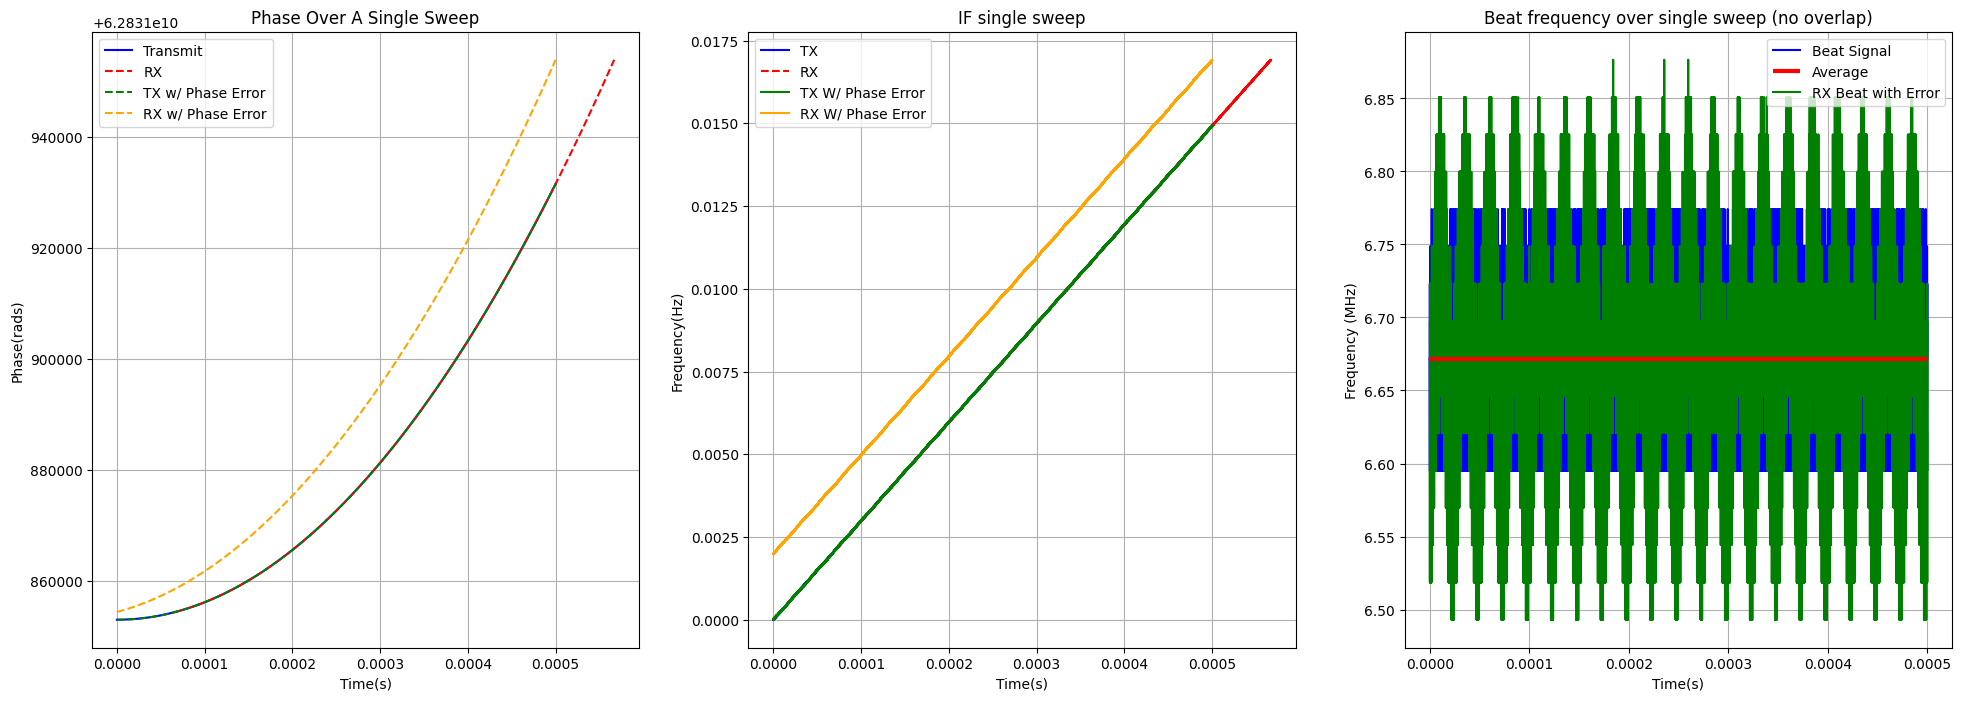

In [ ]:
"""
***** This blocks takes a while to render (30~60s) ***** 
"""
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

t_phase = np.linspace(0, T_s, n_samples)
tau_phase_delayed = np.linspace(tau, T_s+tau, n_samples)

phase = phi_tx(t_phase, f_c_hz, alpha)
phase_tau = phi_tx(tau_phase_delayed, f_c_hz, alpha)

phase_error_for_tx = basic_error_func(t_phase, 1, 40000)
phase_tx_with_error = phi_tx_error(t_phase, f_c_hz, alpha, phase_error_for_tx)


phase_error_for_rx = basic_error_func(tau_phase_delayed, 1, 40000)
phase_rx_with_error = phi_tx_error(tau_phase_delayed, f_c_hz, alpha, phase_error_for_rx)

# Plot Phase for single sweep 

axes[0].plot(t_phase, phase, color='blue', label="TX(Ideal)")
axes[0].plot(tau_phase_delayed, phase_tau,color='red',linestyle="--",label="RX(Ideal)")
axes[0].plot(t_phase, phase_tx_with_error,color='green',linestyle="--",label="TX w/ Phase Error")
axes[0].plot(t_phase, phase_rx_with_error,color='orange',linestyle="--",label="RX w/ Phase Error")

axes[0].set_xlabel("Time(s)")
axes[0].set_ylabel("Phase(rads)")
axes[0].set_title("Phase Over A Single Sweep")
axes[0].grid()
axes[0].legend()

# Plot Instantaneous Frequency (d/dt of phase)
axes[1].plot(t_phase[1:,], np.diff(phase),color='blue', label="TX(Ideal)")
axes[1].plot(tau_phase_delayed[1:,], np.diff(phase_tau),color='red',linestyle="--",label="RX(Ideal)")
axes[1].plot(t_phase[1:,], np.diff(phase_tx_with_error),color='green', label="TX W/ Phase Error")
axes[1].plot(t_phase[1:,], np.diff(phase_rx_with_error),color='orange', label="RX W/ Phase Error")
axes[1].set_xlabel("Time(s)")
axes[1].set_ylabel("Frequency(Hz)")
axes[1].set_title("IF single sweep")
axes[1].grid()
axes[1].legend()

# Plot Beat Signal
# below we do (phase_tau - phase) just to get the right sign convention. mathematical understanding is that it's (phase - phase_tau). But in a real mixer, 
# the phase is actually in the cosine, so HW doesn't actually care about the input sign. 
# It's just that when we look at the phase directly, we can get the wrong sign. 
phi_b = np.unwrap(phase_tau - phase)  # phase difference
dt = t_phase[1]-t_phase[0]
beat_freq = np.diff(phi_b) / (2*np.pi*dt) 

phi_b_error = np.unwrap(phase_rx_with_error - phase_tx_with_error)
beat_freq_with_error = np.diff(phi_b_error) / (2*np.pi*dt) 

axes[2].plot(t_phase[1:], beat_freq/1e6,  color='blue', label="Beat Signal", zorder=2)
axes[2].hlines(np.mean(beat_freq)/1e6, 0, t_phase[-1], color='red', label="Average", linewidth=3, zorder=7)
axes[2].plot(t_phase[1:], beat_freq_with_error/1e6, color='green', label="RX Beat with Error", zorder=5)
axes[2].set_title("Beat frequency over single sweep (no overlap)")
axes[2].set_xlabel("Time(s)")
axes[2].set_ylabel("Frequency (MHz)")
axes[2].grid()
axes[2].legend()

fig.show()

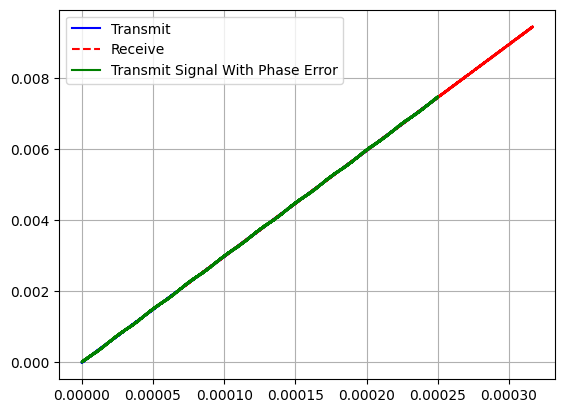

In [5]:
trunc = t_phase.shape[0]//2
plt.plot(t_phase[:trunc][1:,], np.diff(phase[:trunc]),color='blue', label="Transmit")
plt.plot(tau_phase_delayed[:trunc][1:,], np.diff(phase_tau[:trunc]),color='red',linestyle="--",label="Receive")
phase_error = basic_error_func(t_phase, 1, 40000)
phase_with_error = phi_tx_error(t_phase, f_c_hz, alpha, phase_error)

plt.plot(t_phase[:trunc][1:,], np.diff(phase_with_error[:trunc]),color='green', label="Transmit Signal With Phase Error")

plt.grid()
plt.legend()

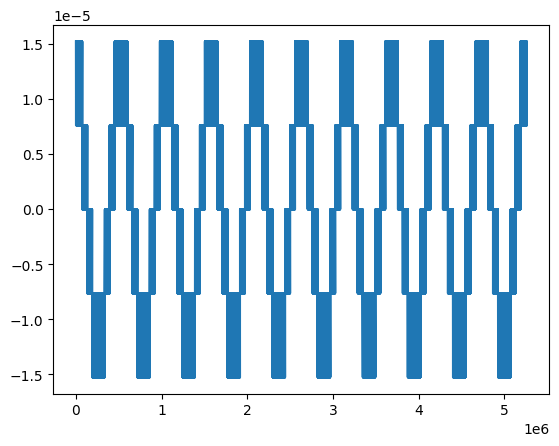

In [6]:
plt.plot(np.diff(phase_with_error[:trunc]) - np.diff(phase[:trunc]))

In [ ]:

s_tx = np.exp(1j*phi_tx(t,         f_c_hz, alpha))
s_rx = np.exp(1j*phi_tx(t_delayed, f_c_hz, alpha))

plt.figure(figsize=(6,3))
plt.plot(t*1e6, s_tx, label='TX')
plt.plot(t*1e6, np.real(s_rx), label='RX (delayed)')
plt.xlim(0, 200)               # zoom to first 200 µs
plt.xlabel('time [µs]'); plt.legend(); plt.tight_layout()


NameError: name 't' is not defined

/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/humdaan/repos/fmcw/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(np.float64(0.0),
 np.float64(25.0),
 np.float64(-1.0999999999999857),
 np.float64(1.0999999999999985))

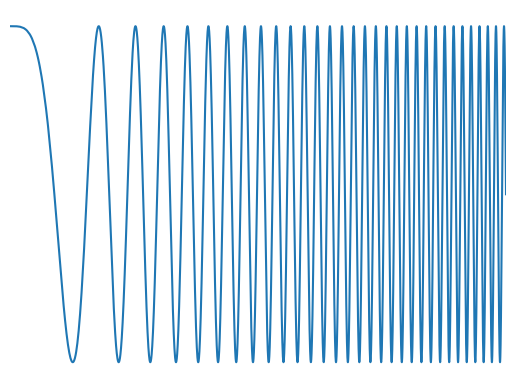

In [56]:
# plt.plot(t_phase, np.exp(1j*phase))
plt.plot(t_phase*1e6, np.exp(1j*phi_tx(t_phase, f_c_hz, alpha)))
plt.plot(tau_phase_delayed*1e6, np.exp(1j*phi_tx(t_phase, f_c_hz, alpha)))
# plt.plot(tau_phase_delayed*1e6, np.exp(1j*phi_tx(tau_phase_delayed, f_c_hz, alpha)))

plt.xlim(0, 25)
plt.axis('off')


In [51]:
np.ptp(t_phase - tau_phase_delayed)

np.float64(1.0842021724855044e-19)

In [54]:
np.min(np.diff(t_phase - tau_phase_delayed))

np.float64(-5.421010862427522e-20)

In [55]:
np.isclose(tau, tau_phase_delayed)

array([ True,  True,  True, ..., False, False, False], shape=(10526250,))